In [1]:
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from photutils import DAOStarFinder

In [2]:
%matplotlib notebook

<IPython.core.display.Javascript object>


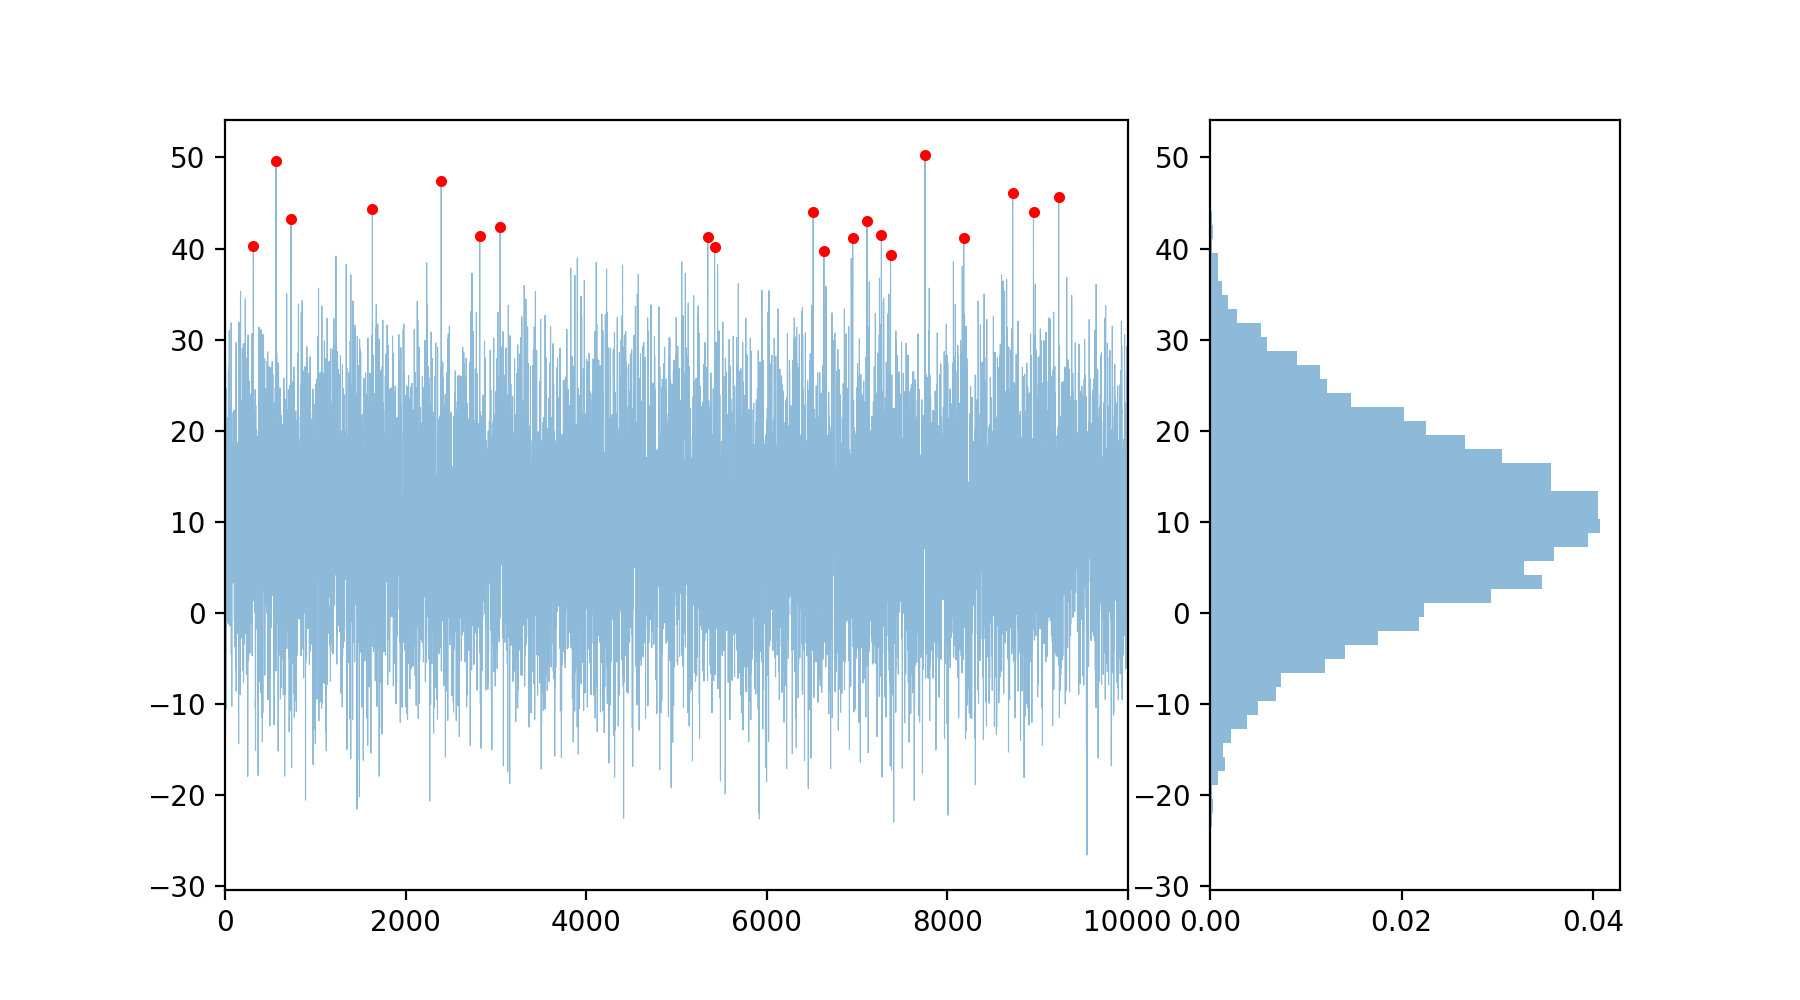

In [3]:
np.random.seed(1)

source = st.norm(10,10)
sampsize = 10000
npeaks = 20
samp = source.rvs(sampsize)
extremes = samp[samp.argsort()[-npeaks:]]

fig = plt.figure(figsize=(9,5))
grid = fig.add_gridspec(1,3)
ax0 = fig.add_subplot(grid[:2])
ax0.plot(samp,lw=0.4,alpha=0.5)
ax0.plot(samp.argsort()[-npeaks:],extremes,'.r')
ax0.set(xlim=[0,sampsize])
ax1 = fig.add_subplot(grid[2])
ax1.hist(samp,orientation='horizontal',bins=50,density=True,alpha=0.5);

<IPython.core.display.Javascript object>


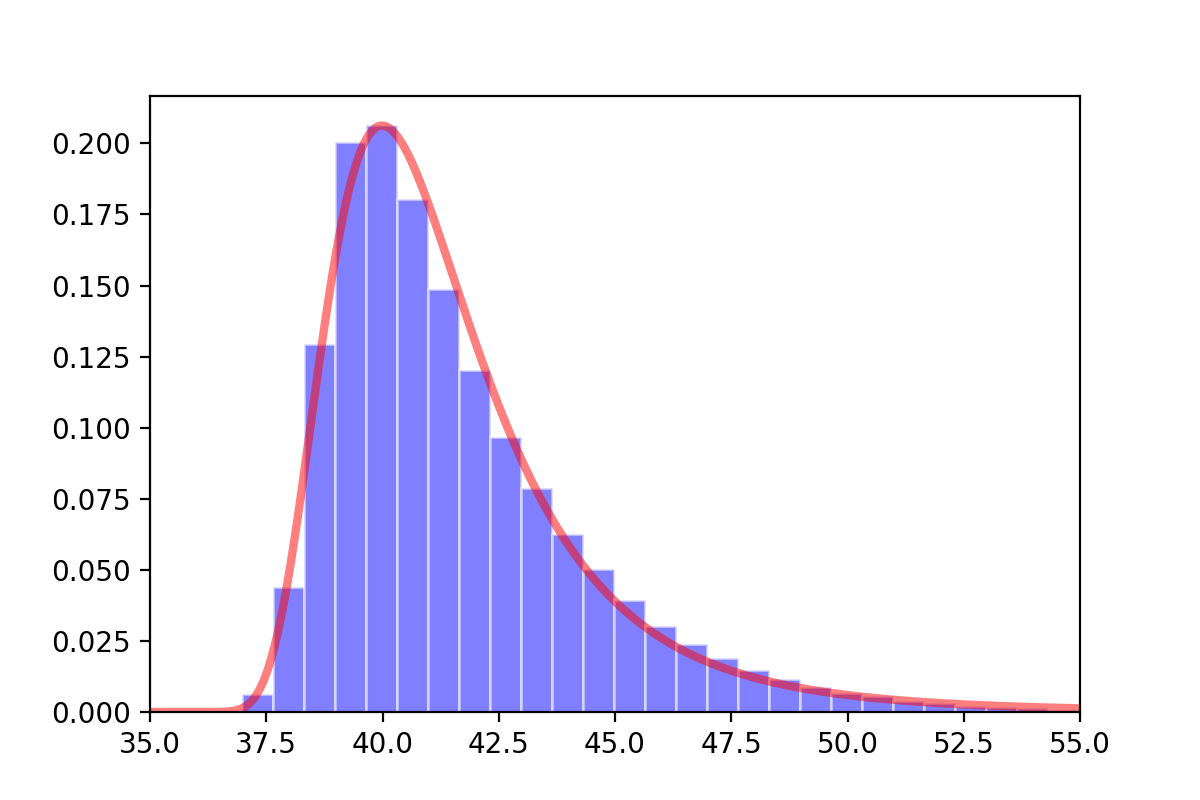

In [4]:
for i in range(sampsize):
    samp = source.rvs(sampsize)
    extremes = np.concatenate((extremes,samp[samp.argsort()[-npeaks:]]))

xtest = np.linspace(30,65,1000)
pars = st.genextreme.fit(extremes)
fig = plt.figure(figsize=(6,4))
ax0 = fig.add_subplot(1,1,1)
ax0.hist(extremes,bins=50,density=True,edgecolor='w',color='b',alpha=0.5)
ax0.plot(xtest,st.genextreme(pars[0], pars[1], pars[2]).pdf(xtest),lw=3,color='r',alpha=0.5)
ax0.set(xlim=[35,55]);

<IPython.core.display.Javascript object>


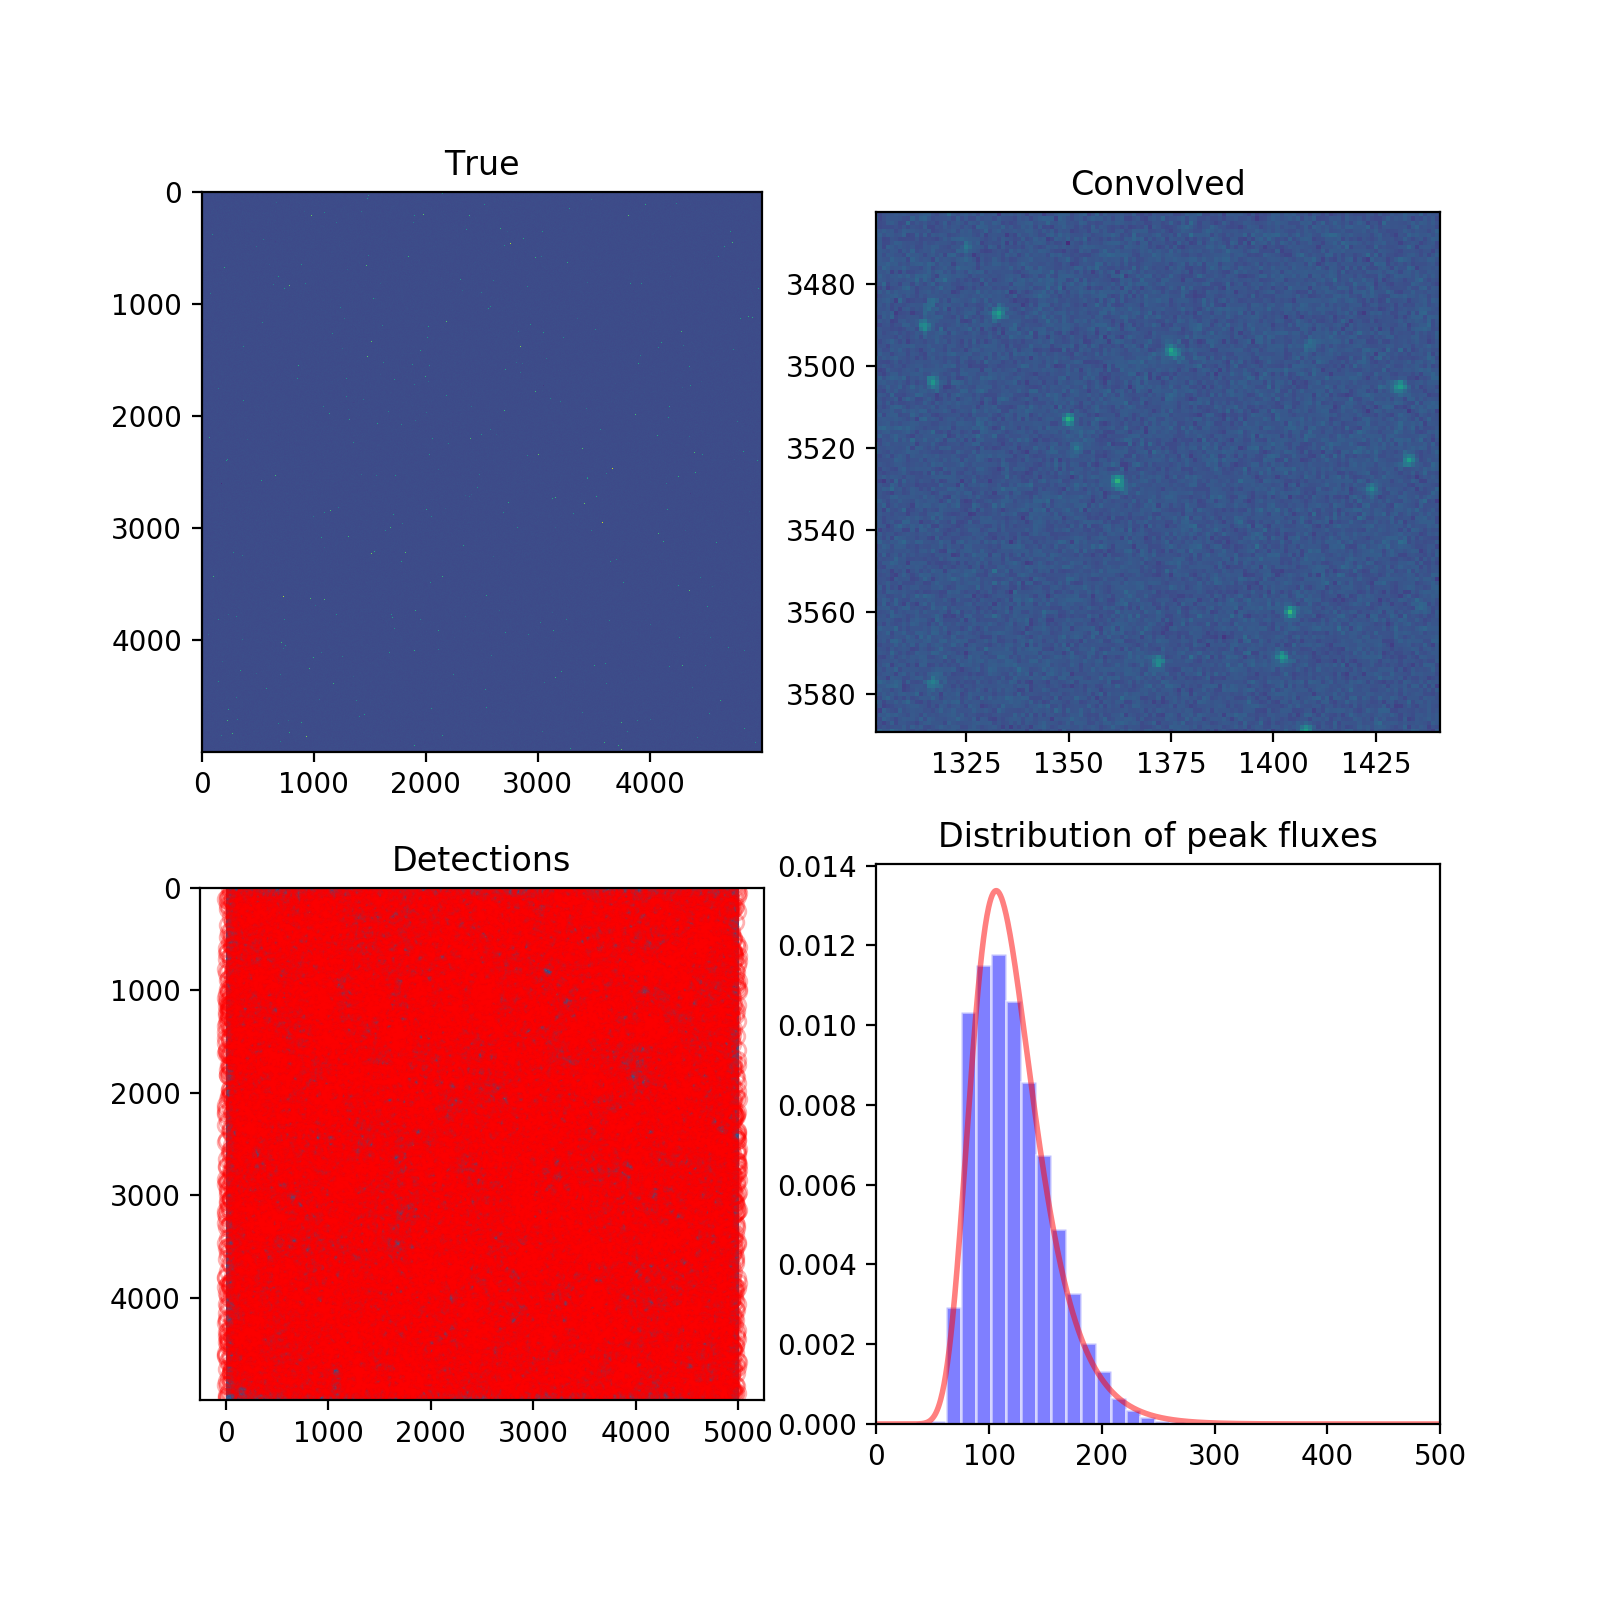

In [14]:
np.random.seed(1)

background = st.norm(200,10)
source_occurrence = st.bernoulli(0.001)
source = st.norm(600,300)

kernel = Gaussian2DKernel(x_stddev=1)

sampsize = 5000
samp_true = background.rvs([sampsize,sampsize])+source_occurrence.rvs([sampsize,sampsize]) * source.rvs([sampsize,sampsize])
samp_conv = background.rvs([sampsize,sampsize])+convolve(samp_true,kernel)

daofind = DAOStarFinder(fwhm=1.0, threshold=4*samp_conv.std())  
sources = daofind(samp_conv - np.median(samp_conv))
xtest = np.linspace(0,500,1000)
pars = st.genextreme.fit(sources['peak'].data)


fig = plt.figure(figsize=(8,8))
grid = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(grid[0])
ax0.imshow(samp_true)
ax0.set(title='True')
ax1 = fig.add_subplot(grid[1])
ax1.imshow(samp_conv)
ax1.set(title='Convolved')
ax2 = fig.add_subplot(grid[2])
ax2.imshow(samp_conv)
ax2.plot(sources['xcentroid'],sources['ycentroid'],'or',markerfacecolor='none',alpha=0.3)
ax2.set(title='Detections')
ax3 = fig.add_subplot(grid[3])
ax3.hist(sources['peak'].data,bins=20,density=True,edgecolor='w',color='b',alpha=0.5)
ax3.plot(xtest,st.genextreme(pars[0], pars[1], pars[2]).pdf(xtest),lw=2,color='r',alpha=0.5)
ax3.set(xlim=[0,500]);
ax3.set(title='Distribution of peak fluxes');